In [8]:
import networkx as nx #import NetworkX
import numpy as np #import numpy for ...
import community #import community (https://pypi.python.org/pypi/python-louvain/0.3)
import powerlaw #import powerlaw library for testing fits
#force drawing of graphs inline for ipython notebook
%matplotlib inline 
import matplotlib.pyplot as plt #import matplotlib for plotting/drawing grpahs

# custom imports 
# WE USE PANDAS INSTEAD OF CSV -> more flexible
import pandas as pd
# for dict sorting
import operator

In [9]:
def create_dependency_graph(csv, delimiter, min_edges=0):
    # create an empty DependencyGraph
    dep_graph = nx.DiGraph()
    # create a pandas dataframe from the csv file and the delimiter
    df = pd.read_csv(csv, delimiter=delimiter, header=0)
    # requirements format
    # print df.head(5)
    # we create nodes for all the unique package names in the dataframe
    dep_graph.add_nodes_from(df.package_name.unique())
    # this is where the magic happens: we create edges between packages
    # and their dependencies if they exist: they are notnull().
    # pandas loc function finds all these packages
    edges = df.loc[df['requirement'].notnull(), ['package_name', 'requirement']].values
    # we add the edges in the networkx graph between these nodes
    dep_graph.add_edges_from(edges)
    # CHECK THIS??
    # we find all the isolated nodes: i.e. the nodes
    # that do not have dependencies: they are not interesting
    deg = dep_graph.degree()
    to_remove = [n for n in deg if deg[n] <= min_edges]
    # and remove these nodes from the graph
    dep_graph.remove_nodes_from(to_remove)
    return dep_graph 

In [10]:
print 'PRELIMINARY ANALYSIS'
# let us create our dependency graph, our dataset has ','s as delimiters

# FOR C
# dep_graph = create_dependency_graph('c_dependencies.csv', ',', min_edges=0)

# FOR PYTHON
dep_graph = create_dependency_graph('p_dependencies.csv', ',', min_edges=0)

# Number of edges
dep_order = dep_graph.order()
# Number of edges
dep_size = dep_graph.size()
# Average degree for directed network
avg_deg = float(dep_size) / dep_order
# all the in_degrees
in_degrees = dep_graph.in_degree() 
# all the out_degrees 
out_degrees = dep_graph.out_degree()

print 'Number of nodes in the dependency graph:'
print dep_order
print 'Number of edges in the dependency graph:'
print dep_size
print 'Average degree in the dependency graph:'
print avg_deg

PRELIMINARY ANALYSIS
Number of nodes in the dependency graph:
26274
Number of edges in the dependency graph:
72641
Average degree in the dependency graph:
2.76474842049


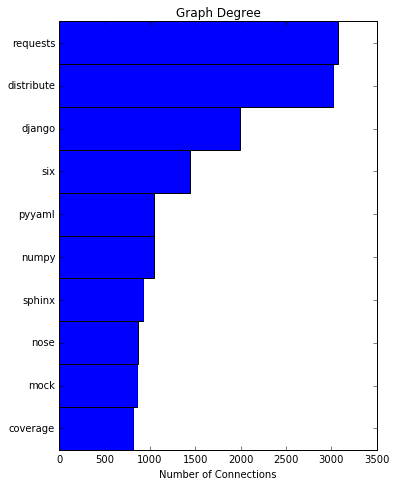

In [11]:
sorted_dict = sorted(dep_graph.in_degree().items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
_ = ax.set_yticklabels(xlabels)
ax.set_xlabel('Number of Connections')
ax.set_title('Graph Degree')
fig.subplots_adjust(left=0.27, bottom=0.1, top=0.95)

DEGREE ANALYSIS


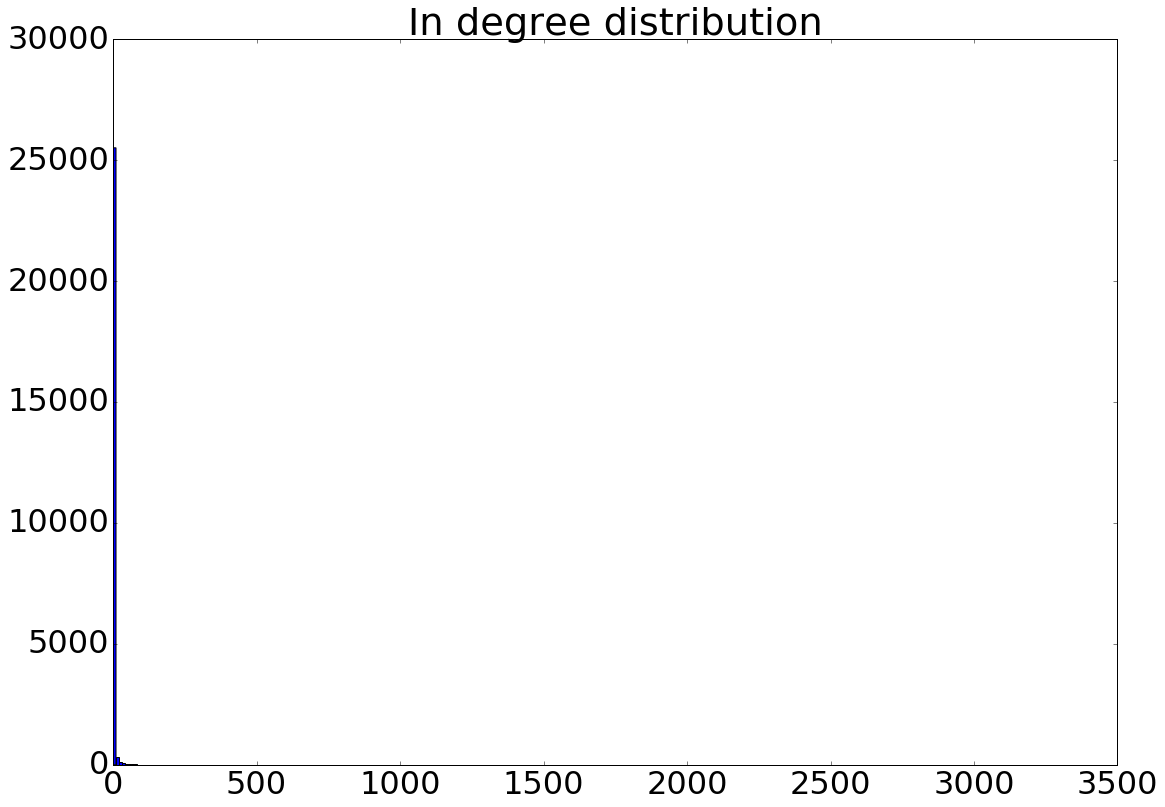

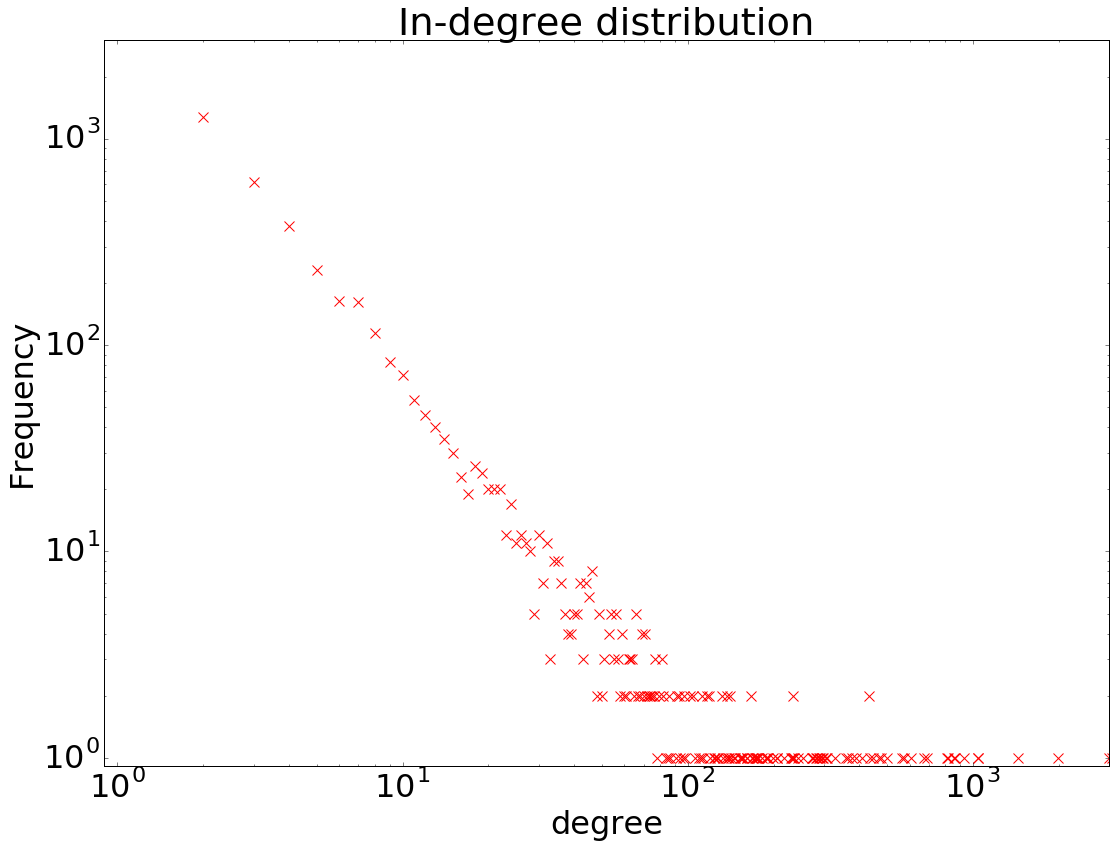

Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


-4.91046404564 9.08611154518e-07
-0.917812988489 0.358716781143
-4.91273455116 8.98148388715e-07
1.59685738613
3.0


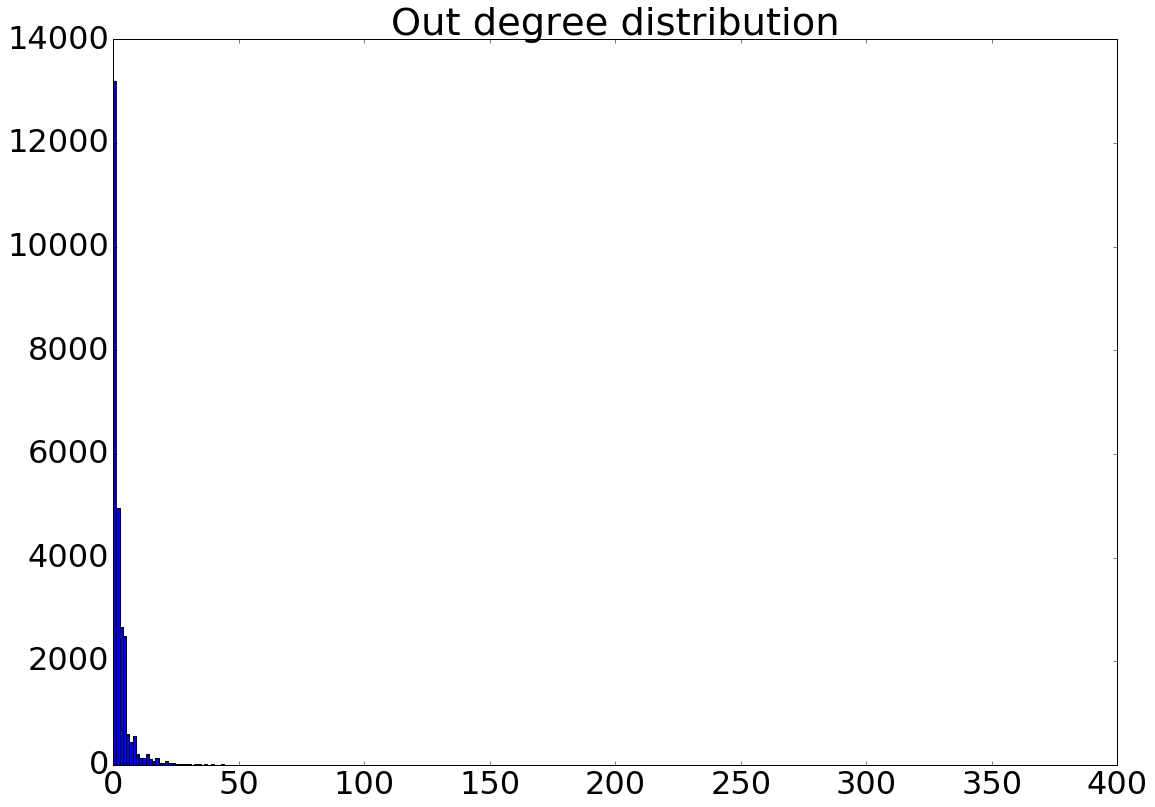

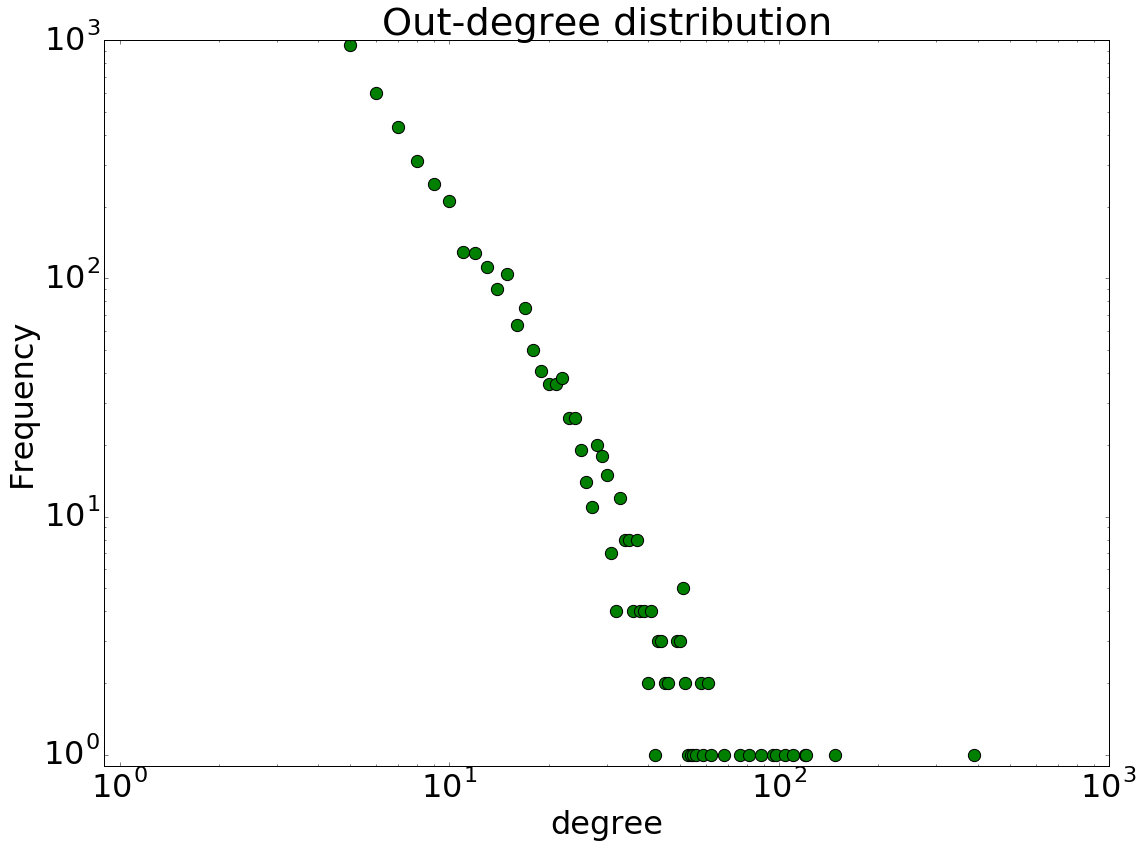

In [12]:
print 'DEGREE ANALYSIS'

import collections

fig_size= [18,13]

#plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 32, "figure.figsize": fig_size})

#Histogram of in-degrees, Plot and save to png
plt.hist(in_degrees.values(), bins=300, normed=False)
plt.title('In degree distribution')
plt.savefig('in-degree.png')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') #set y scale to be log
plt.xscale('log') #set x scale to be log
#create a dictionary where key is degree and value is the number of times that degree is found
#See the python collections Counter for more information 
in_degree_counts = dict(collections.Counter(in_degrees.values())) 
#Create scatter plot with degree on x-axis and counts on y-axis (red colour, x marker and size 150)
plt.scatter(in_degree_counts.keys(), in_degree_counts.values(), c='r', marker='x', s=100)
plt.xlim((.9, 3e3)) #set x axis limits
plt.ylim((0, 3e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

#Fit a powerlaw to data see paper above for more details
import powerlaw
fit = powerlaw.Fit(in_degree_counts.values())
R, p = fit.distribution_compare('exponential','lognormal',  normalized_ratio=True)
print R, p
R, p = fit.distribution_compare('power_law','lognormal',  normalized_ratio=True)
print R, p
R, p = fit.distribution_compare('exponential','power_law',  normalized_ratio=True)
print R, p

print fit.power_law.alpha
print fit.power_law.xmin


#Histogram of out-degrees, plot and save to png
plt.hist(out_degrees.values(), bins=300, normed=False)
plt.title('Out degree distribution')
plt.savefig('out-degree.png')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') #set y scale to be log
plt.xscale('log') #set x scale to be log
#create a dictionary where key is degree and value is the number of times that degree is found
#See the python collections Counter for more information 
out_degree_counts = dict(collections.Counter(out_degrees.values())) 
#Create scatter plot with degree on x-axis and counts on y-axis (green colour, o marker and size 150)
plt.scatter(out_degree_counts.keys(), out_degree_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

In [102]:
print 'PATH ANALYSIS'

#Note some of these things can be calculated more easily in NetworkX

if not 'avg_path_length' in globals(): #only calculate this if its not been calculated before
    max_path_length = 0
    total = 0.0
    for n in dep_graph: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(dep_graph, n) # generate shortest paths from node n to all others
        total += sum(path_length.values()) #total of all shortest paths from n
    
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path we see.
            max_path_length = max(path_length.values())         
    avg_path_length = total / (dep_order*(dep_order - 1)) #calculate average.




PATH ANALYSIS


In [92]:
avg_pathlen = []
subgraph_size = []
for subgraph in nx.connected_component_subgraphs(dep_graph.to_undirected()):
    n = len(subgraph)
    if n > 1:
        subgraph_size.append(n)
        avg_pathlen.append(nx.average_shortest_path_length(subgraph))

avg_clustering = nx.average_clustering(dep_graph.to_undirected())
apl = np.average(avg_pathlen, weights=subgraph_size)
print(apl, avg_clustering)

(4.0958256781428659, 0.06866673549587546)


CENTRALITY MEASURES
2.56209409372e-08
0.000100866335946


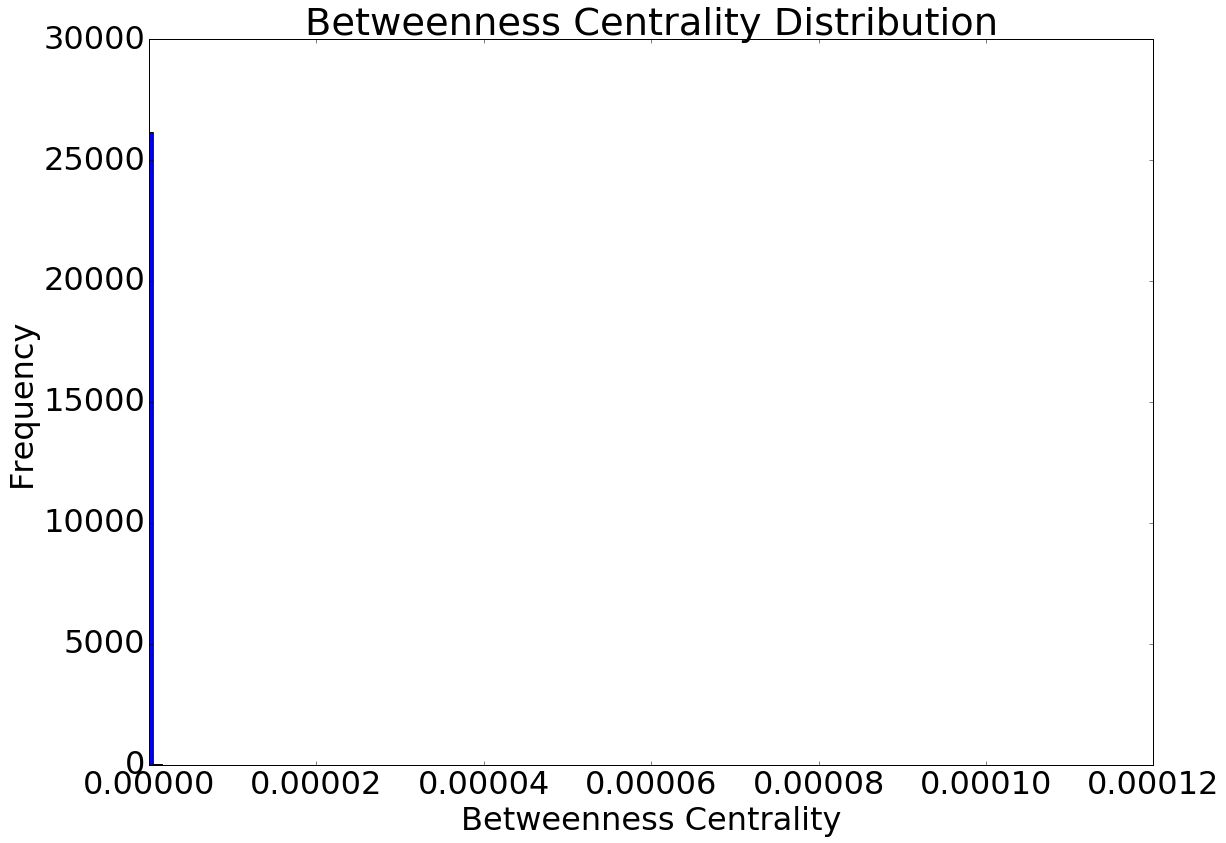

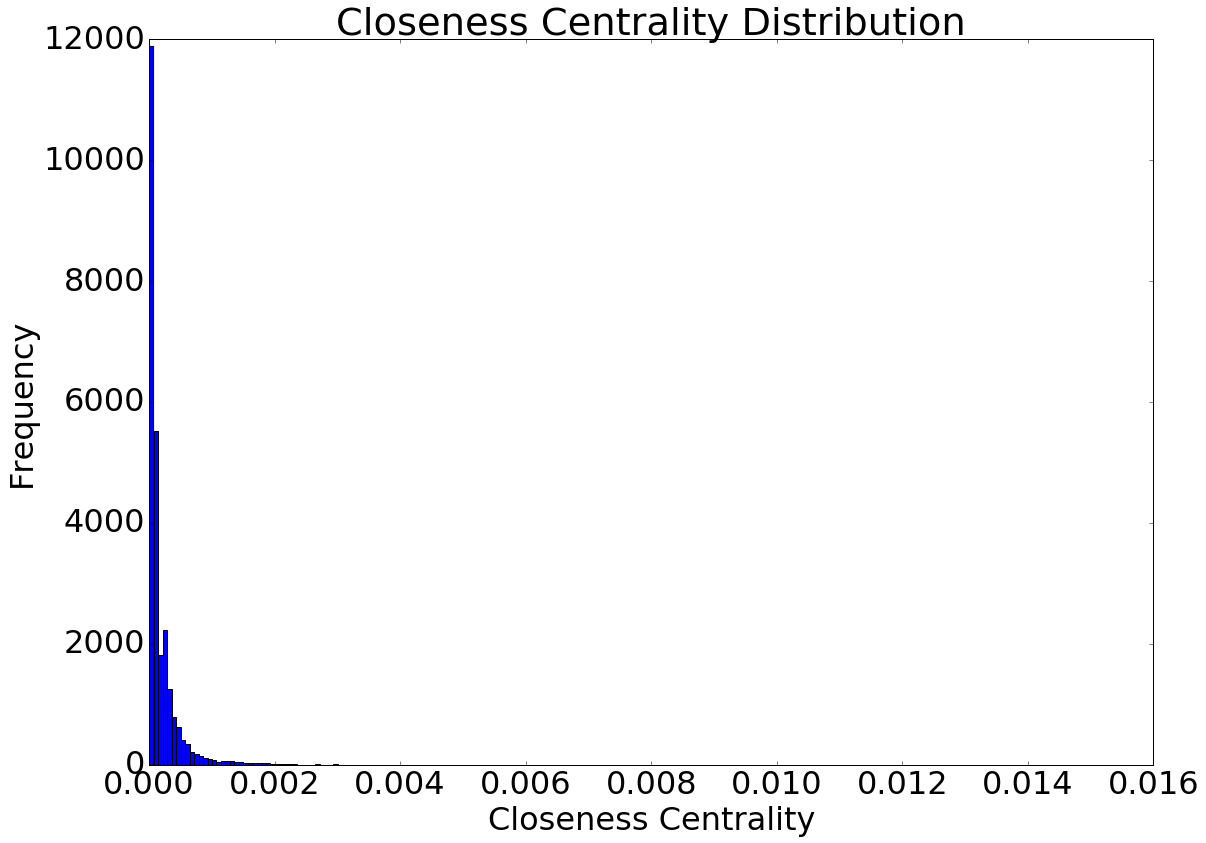

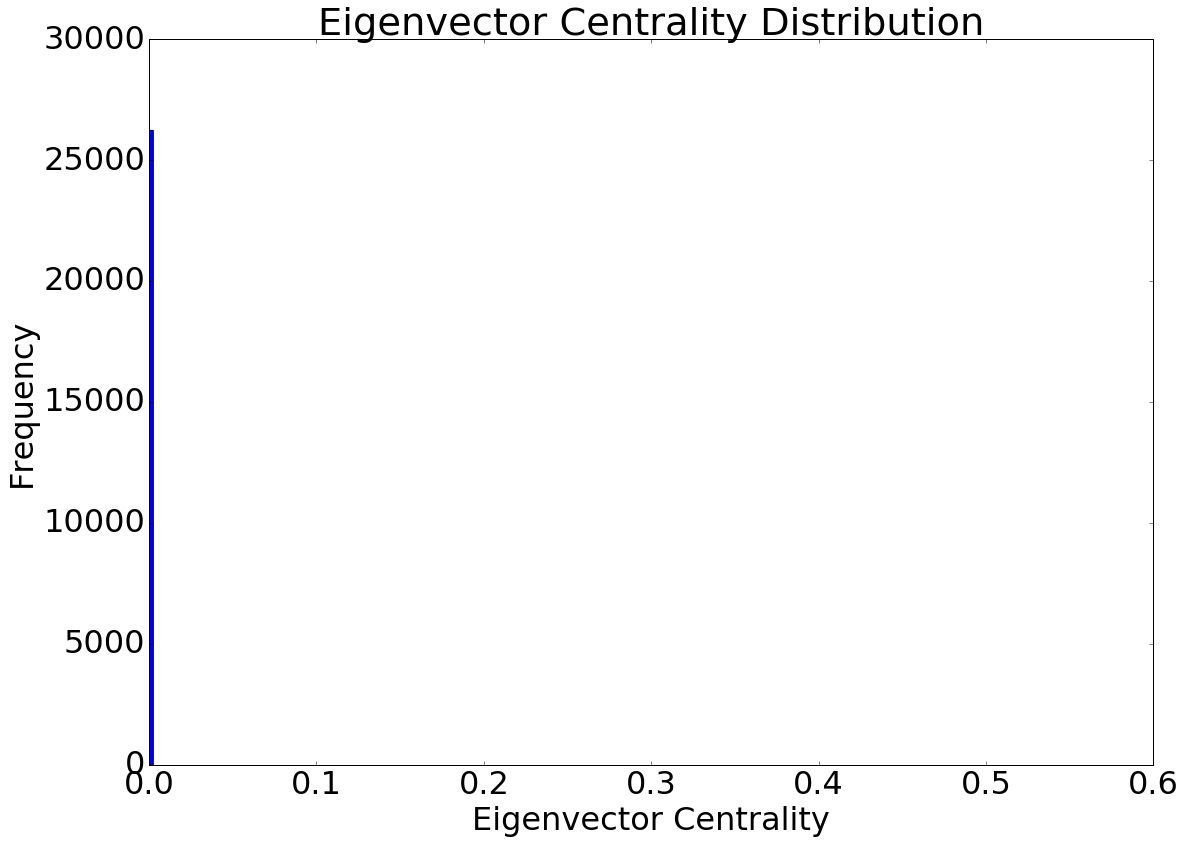

In [93]:
print 'CENTRALITY MEASURES'
if not 'bet_cen' in globals(): #only calculate this if its not been calculated before
    avg_clustering = nx.average_clustering(dep_graph.to_undirected())
    bet_cen = nx.betweenness_centrality(dep_graph)
    clo_cen = nx.closeness_centrality(dep_graph)
    eig_cen = nx.eigenvector_centrality(dep_graph)
#Histogram of in-degrees

print np.mean(bet_cen.values())
print max(bet_cen.values())

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 32})

plt.hist(bet_cen.values(), bins=200, normed=False) #Try varying the bins, also look at the hist manual
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Betweenness Centrality Distribution')
plt.show()
plt.hist(clo_cen.values(), bins=200, normed=False) #Try varying the bins, also look at the hist manual
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Closeness Centrality Distribution')
plt.show()
plt.hist(eig_cen.values(), bins=200, normed=False) #Try varying the bins, also look at the hist manual
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Eigenvector Centrality Distribution')
plt.show()


REWRITE THIS: USEFUL OBSERVATION DOE

So I'm not sure... by the definition above, the clustering coefficient seems to be quite small. That means that node neighborhoods are not connected anywhere near as much as they could be, and that this is NOT a small-world graph. On the other hand, the average path length  L∼logN
 , which is another definition of a small-world graph. I guess these could be reconciled if there are a few very very important nodes that act as hubs, but the "spokes" that come out of the hubs are relatively independent. Those hubs appear to be requests and django, and maybe six.

In [14]:
nx.write_gexf(dep_graph, "dependencies_p.gexf") #write in gephi format